In [1]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from tqdm.notebook import tqdm
tqdm.get_lock().locks = []

In [2]:
class logmeanexp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, f_x):
        f_x = f_x.detach()
        ctx.save_for_backward(f_x)
        return torch.log(torch.mean(torch.exp(f_x)))

    @staticmethod
    def backward(ctx, grad_output):
        with torch.no_grad():
            f_x, = ctx.saved_tensors
            grad_input_f = torch.exp(f_x) / torch.sum(torch.exp(f_x))
        return grad_input_f * grad_output


def conjugate_kl(f_x):
    return logmeanexp.apply(f_x)


class gamma_reverse_kl(torch.autograd.Function):
    @staticmethod
    def forward(ctx, f_x):
        f_x = f_x.detach()
        gamma = torch.max(f_x) - 1 + 0.0001
        for _ in range(10000):
            F_gamma = -torch.mean(1 / (1 - f_x + gamma)) + 1
            F_gamma_derivative = torch.mean(1 / ((1 - f_x + gamma) ** 2))
            step = F_gamma / F_gamma_derivative
            gamma = gamma - step
            if torch.abs(step).item() < 1e-6:
                break
        ctx.save_for_backward(f_x, gamma)
        return gamma

    @staticmethod
    def backward(ctx, grad_output):
        with torch.no_grad():
            f_x, gamma = ctx.saved_tensors
            F_gamma_gradient = -(1 / float(f_x.size(0))) * (1 / ((1 - f_x + gamma) ** 2))
            F_gamma_derivative = torch.mean(1 / ((1 - f_x + gamma) ** 2))
            grad_input_f = -F_gamma_gradient / F_gamma_derivative
        return grad_input_f * grad_output


def conjugate_reverse_kl(f_x):
    gamma = gamma_reverse_kl.apply(f_x)
    return torch.mean(-torch.log(1 - f_x + gamma)) + gamma


def conjugate_chi2(f_x):
    return torch.mean(f_x) + (1 / 4) * torch.mean((f_x - torch.mean(f_x)) ** 2)


class gamma_reverse_chi2(torch.autograd.Function):
    @staticmethod
    def forward(ctx, f_x):
        f_x = f_x.detach()
        gamma = torch.max(f_x) - 1 + 1e-6
        for _ in range(10000):
            F_gamma = -torch.mean(1 / torch.sqrt(1 - f_x + gamma)) + 1
            F_gamma_derivative = torch.mean(1 / (2 * (torch.sqrt(1 - f_x + gamma) ** 3)))
            step = F_gamma / F_gamma_derivative
            gamma = gamma - step
            if torch.abs(step).item() < 1e-6:
                break
        ctx.save_for_backward(f_x, gamma)
        return gamma

    @staticmethod
    def backward(ctx, grad_output):
        with torch.no_grad():
            f_x, gamma = ctx.saved_tensors
            F_gamma_gradient = -(1 / float(f_x.size(0))) * (1 / (2 * (torch.sqrt(1 - f_x + gamma) ** 3)))
            F_gamma_derivative = torch.mean(1 / (2 * (torch.sqrt(1 - f_x + gamma) ** 3)))
            grad_input_f = -F_gamma_gradient / F_gamma_derivative
        return grad_input_f * grad_output


def conjugate_reverse_chi2(f_x):
    gamma = gamma_reverse_chi2.apply(f_x)
    return torch.mean(2 - 2 * torch.sqrt(1 - f_x + gamma)) + gamma


class gamma_hellinger2(torch.autograd.Function):
    @staticmethod
    def forward(ctx, f_x):
        f_x = f_x.detach()
        gamma = torch.max(f_x) - 1 + 1e-2
        for _ in range(10000):
            F_gamma = -torch.mean(1 / ((1 - f_x + gamma) ** 2)) + 1
            F_gamma_derivative = torch.mean(2 / ((1 - f_x + gamma) ** 3))
            step = F_gamma / F_gamma_derivative
            gamma = gamma - step
            if torch.abs(step).item() < 1e-6:
                break
        ctx.save_for_backward(f_x, gamma)
        return gamma

    @staticmethod
    def backward(ctx, grad_output):
        with torch.no_grad():
            f_x, gamma = ctx.saved_tensors
            F_gamma_gradient = -(1 / float(f_x.size(0))) * (2 / ((1 - f_x + gamma) ** 3))
            F_gamma_derivative = torch.mean(2 / ((1 - f_x + gamma) ** 3))
            grad_input_f = -F_gamma_gradient / F_gamma_derivative
        return grad_input_f * grad_output


def conjugate_hellinger2(f_x):
    gamma = gamma_hellinger2.apply(f_x)
    return torch.mean((f_x - gamma) / (1 - f_x + gamma)) + gamma


class gamma_js(torch.autograd.Function):
    @staticmethod
    def forward(ctx, f_x):
        f_x = f_x.detach()
        gamma = torch.max(f_x) - math.log(2) + 1e-5
        for _ in range(10000):
            F_gamma = -torch.mean(1 / (2 * torch.exp(gamma - f_x) - 1)) + 1
            F_gamma_derivative = torch.mean((2 * torch.exp(f_x - gamma)) / ((torch.exp(f_x - gamma) - 2) ** 2))
            step = F_gamma / F_gamma_derivative
            gamma = gamma - step
            if torch.abs(step).item() < 1e-6:
                break
        ctx.save_for_backward(f_x, gamma)
        return gamma

    @staticmethod
    def backward(ctx, grad_output):
        with torch.no_grad():
            f_x, gamma = ctx.saved_tensors
            F_gamma_gradient = -(1 / float(f_x.size(0))) * (
                (2 * torch.exp(f_x - gamma)) / ((torch.exp(f_x - gamma) - 2) ** 2)
            )
            F_gamma_derivative = torch.mean((2 * torch.exp(f_x - gamma)) / ((torch.exp(f_x - gamma) - 2) ** 2))
            grad_input_f = -F_gamma_gradient / F_gamma_derivative
        return grad_input_f * grad_output


def conjugate_js(f_x):
    gamma = gamma_js.apply(f_x)
    return torch.mean(-torch.log(2 - torch.exp(f_x - gamma))) + gamma


class lambertw(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z):
        z = z.detach()
        w = torch.log(1 + z)
        for i in range(10000):
            step = (w * torch.exp(w) - z) / (torch.exp(w) + w * torch.exp(w))
            w = w - step
            if torch.max(torch.abs(step)).item() < 1e-5:
                break
        ctx.save_for_backward(z, w)
        return w

    @staticmethod
    def backward(ctx, grad_output):
        with torch.no_grad():
            z, w = ctx.saved_tensors
            grad_input_z = w / (z * (1 + w))
        return grad_input_z * grad_output


class gamma_jeffreys(torch.autograd.Function):
    @staticmethod
    def forward(ctx, f_x):
        f_x = f_x.detach()
        gamma = torch.mean(f_x)
        for i in range(10000):
            w = lambertw.apply(torch.exp(1 - f_x + gamma))
            F_gamma = -torch.mean(1 / w) + 1
            F_gamma_derivative = torch.mean((1 / w) - (1 / (w + 1)))
            step = F_gamma / F_gamma_derivative
            gamma = gamma - step
            if torch.abs(step).item() < 1e-6:
                break
        ctx.save_for_backward(f_x, gamma)
        return gamma

    @staticmethod
    def backward(ctx, grad_output):
        with torch.no_grad():
            f_x, gamma = ctx.saved_tensors
            w = lambertw.apply(torch.exp(1 - f_x + gamma))
            F_gamma_gradient = -(1 / float(f_x.size(0))) * ((1 / w) - (1 / (w + 1)))
            F_gamma_derivative = torch.mean((1 / w) - (1 / (w + 1)))
            grad_input_f = -F_gamma_gradient / F_gamma_derivative
        return grad_input_f * grad_output


def conjugate_jeffreys(f_x):
    gamma = gamma_jeffreys.apply(f_x)
    w = lambertw.apply(torch.exp(1 - f_x + gamma))
    return torch.mean(f_x - gamma + w + 1 / w - 2) + gamma


class gamma_triangular(torch.autograd.Function):
    @staticmethod
    def forward(ctx, f_x):
        f_x = f_x.detach()
        gamma = torch.max(f_x) - 1 + 1e-7
        for _ in range(10000):
            F_gamma = -torch.mean((2 / ((1 - f_x + gamma) ** (1/2)) - 1) * (f_x - gamma >= -3)) + 1
            F_gamma_derivative = torch.mean((1 / (((1 - f_x + gamma) ** (1/2)) ** 3)) * (f_x - gamma >= -3))
            step = F_gamma / F_gamma_derivative
            gamma = gamma - step
            if torch.abs(step).item() < 1e-6:
                break
        ctx.save_for_backward(f_x, gamma)
        return gamma

    @staticmethod
    def backward(ctx, grad_output):
        with torch.no_grad():
            f_x, gamma = ctx.saved_tensors
            F_gamma_gradient = -(1 / float(f_x.size(0))) * (
                    1 / (((1 - f_x + gamma) ** (1/2)) ** 3)
            ) * (f_x - gamma >= -3)
            F_gamma_derivative = torch.mean((1 / (((1 - f_x + gamma) ** (1/2)) ** 3)) * (f_x - gamma >= -3))
            grad_input_f = -F_gamma_gradient / F_gamma_derivative
        return grad_input_f * grad_output


def conjugate_triangular(f_x):
    gamma = gamma_triangular.apply(f_x)
    return torch.mean(
        -1 * (f_x - gamma < -3) +
        (4 - 4 * ((1 - f_x + gamma) ** (1 / 2)) - f_x + gamma) * (f_x - gamma >= -3)
    ) + gamma


In [3]:
n_1 = torch.distributions.normal.Normal(loc=torch.Tensor([-1.0]), scale=torch.Tensor([0.3]))

n_2 = torch.distributions.normal.Normal(loc=torch.Tensor([0.5]), scale=torch.Tensor([0.6]))

In [4]:
def get_radon_nikodym(n_1, n_2):
    mu_1, sigma_1, mu_2, sigma_2 = n_1.mean, n_1.stddev, n_2.mean, n_2.stddev
    radon_nikodym = lambda x : (
        (sigma_2 / sigma_1) * torch.exp(
            (1 / 2) * (((x - mu_2) / sigma_2) ** 2 - ((x - mu_1) / sigma_1) ** 2)
        )
    )
    return radon_nikodym

def get_csiszar_potential(n_1, n_2, phi_derivative):
    radon_nikodym = get_radon_nikodym(n_1, n_2)
    csiszar_potential = lambda x: phi_derivative(radon_nikodym(x))
    return csiszar_potential

In [5]:
class Quotient(torch.nn.Module):
    def __init__(self, f):
        super(Quotient, self).__init__()
        self.f = f

    def forward(self, x):
        return self.f(x) - self.f(torch.zeros_like(x))

init_f = lambda: Quotient(
    torch.nn.Sequential(
        torch.nn.Linear(1, 32),
        torch.nn.Softplus(),
        torch.nn.Linear(32, 32),
        torch.nn.Softplus(),
        torch.nn.Linear(32, 1),
    )
)

def get_critic(n_1, n_2, conjugate_fn):
    f = init_f().cuda()
    stable_conjugate_fn = lambda f_x: conjugate_fn(f_x - torch.max(f_x)) + torch.max(f_x)
    lr = 3e-4
    iterations = 100000
    batch_size = 1000
    optimizer = torch.optim.Adam(f.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda i: 1 - i / iterations)
    t = tqdm(range(iterations), ncols='100%')
    for _ in t:
        optimizer.zero_grad()
        x_1 = n_1.sample_n(batch_size).cuda()
        x_2 = n_2.sample_n(batch_size).cuda()
        divergence = torch.mean(f(x_1)) - stable_conjugate_fn(f(x_2)) 
        loss = -divergence
        loss.backward()
        optimizer.step()
        scheduler.step()
        t.set_description(f"divergence: {divergence.item():.5f}")
    return f

/home/dterjek/anaconda3/envs/torch/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


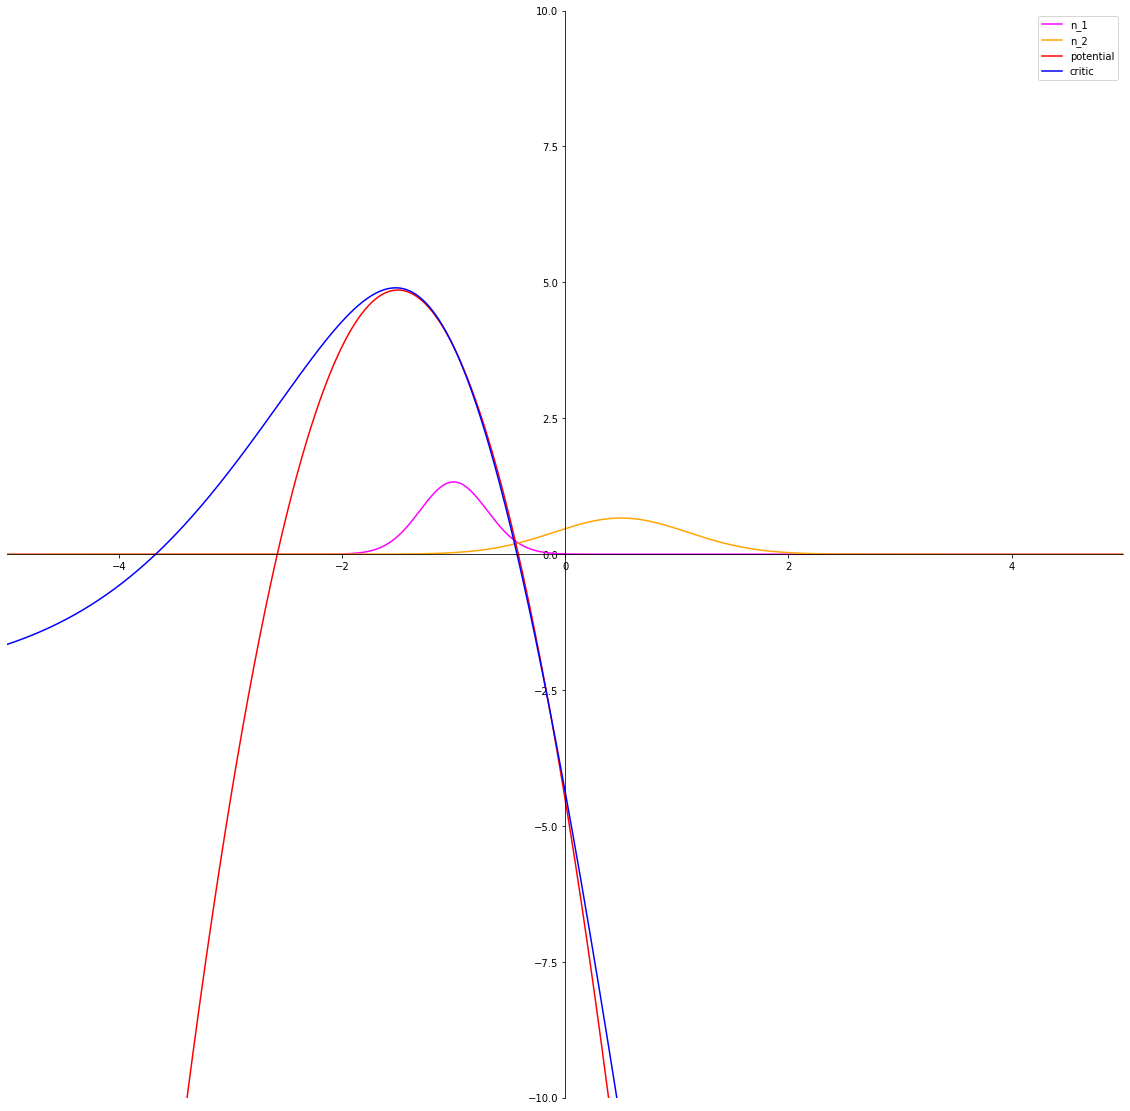

In [6]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlim([-5, 5])
ax.set_ylim([-10, 10])

x = np.linspace(-10,10,2000)
csiszar_potential = get_csiszar_potential(n_1, n_2, lambda x: torch.log(torch.tensor([x])).item())
csiszar_potential_x = np.array(list(map(csiszar_potential, x)))
critic = get_critic(n_1, n_2, conjugate_kl)
critic_x = critic(torch.from_numpy(x).unsqueeze(1).float().cuda()).detach().cpu().numpy()
critic_x = critic_x - critic_x[900] + csiszar_potential_x[900]

plt.plot(x, n_1.log_prob(torch.from_numpy(x)).exp().numpy(), 'magenta', label='n_1')
plt.plot(x, n_2.log_prob(torch.from_numpy(x)).exp().numpy(), 'orange', label='n_2')
plt.plot(x, csiszar_potential_x, 'red', label='potential')
plt.plot(x, critic_x, 'blue', label='critic')

plt.legend(loc='upper right')

plt.show()

/home/dterjek/anaconda3/envs/torch/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


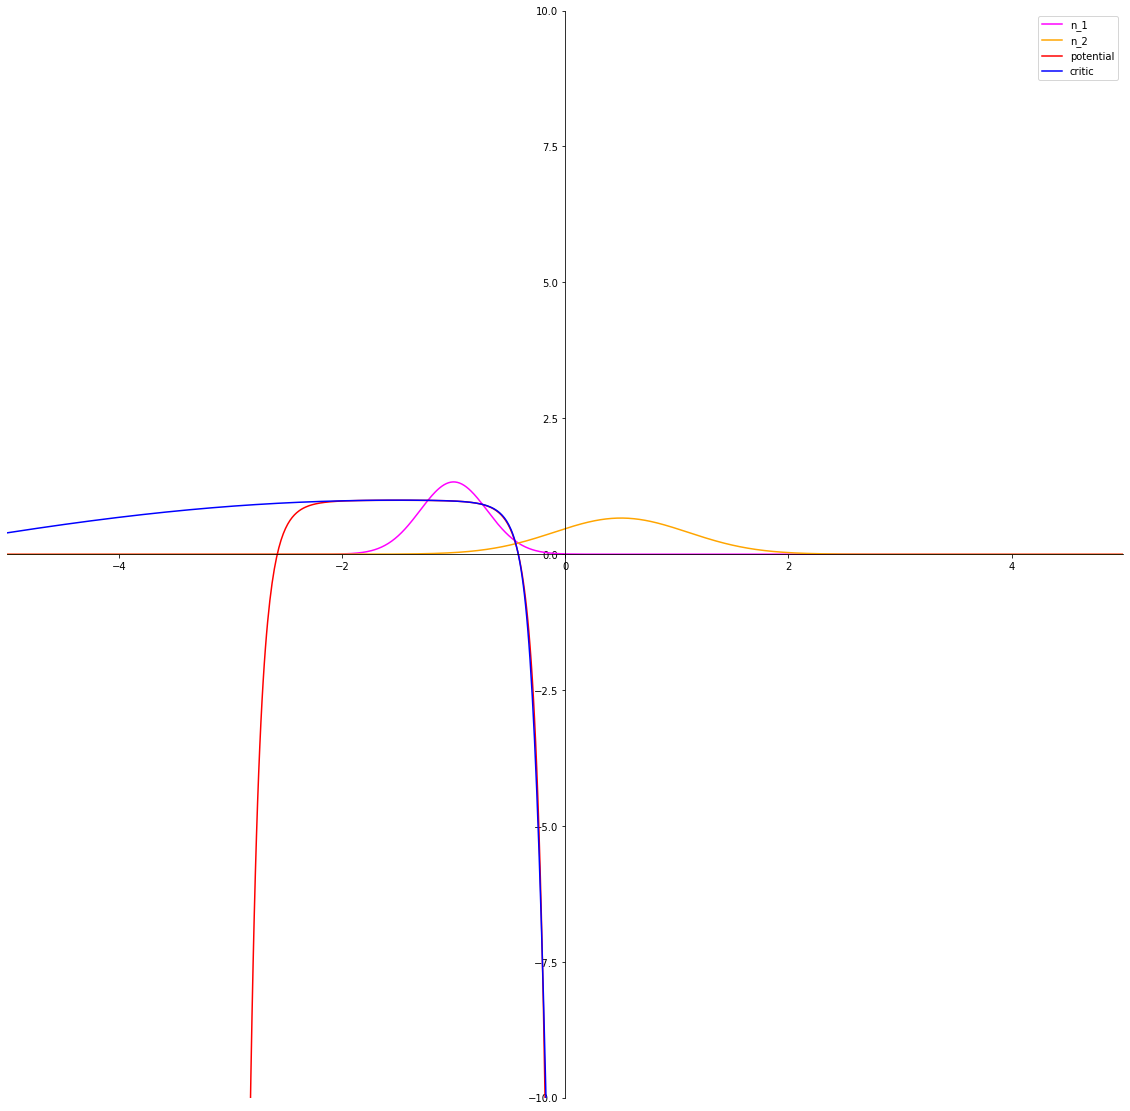

In [7]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlim([-5, 5])
ax.set_ylim([-10, 10])

x = np.linspace(-10,10,2000)
csiszar_potential = get_csiszar_potential(n_1, n_2, lambda x: (x - 1) / x)
csiszar_potential_x = np.array(list(map(csiszar_potential, x)))
critic = get_critic(n_1, n_2, conjugate_reverse_kl)
critic_x = critic(torch.from_numpy(x).unsqueeze(1).float().cuda()).detach().cpu().numpy()
critic_x = critic_x - critic_x[900] + csiszar_potential_x[900]

plt.plot(x, n_1.log_prob(torch.from_numpy(x)).exp().numpy(), 'magenta', label='n_1')
plt.plot(x, n_2.log_prob(torch.from_numpy(x)).exp().numpy(), 'orange', label='n_2')
plt.plot(x, csiszar_potential_x, 'red', label='potential')
plt.plot(x, critic_x, 'blue', label='critic')

plt.legend(loc='upper right')

plt.show()

/home/dterjek/anaconda3/envs/torch/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


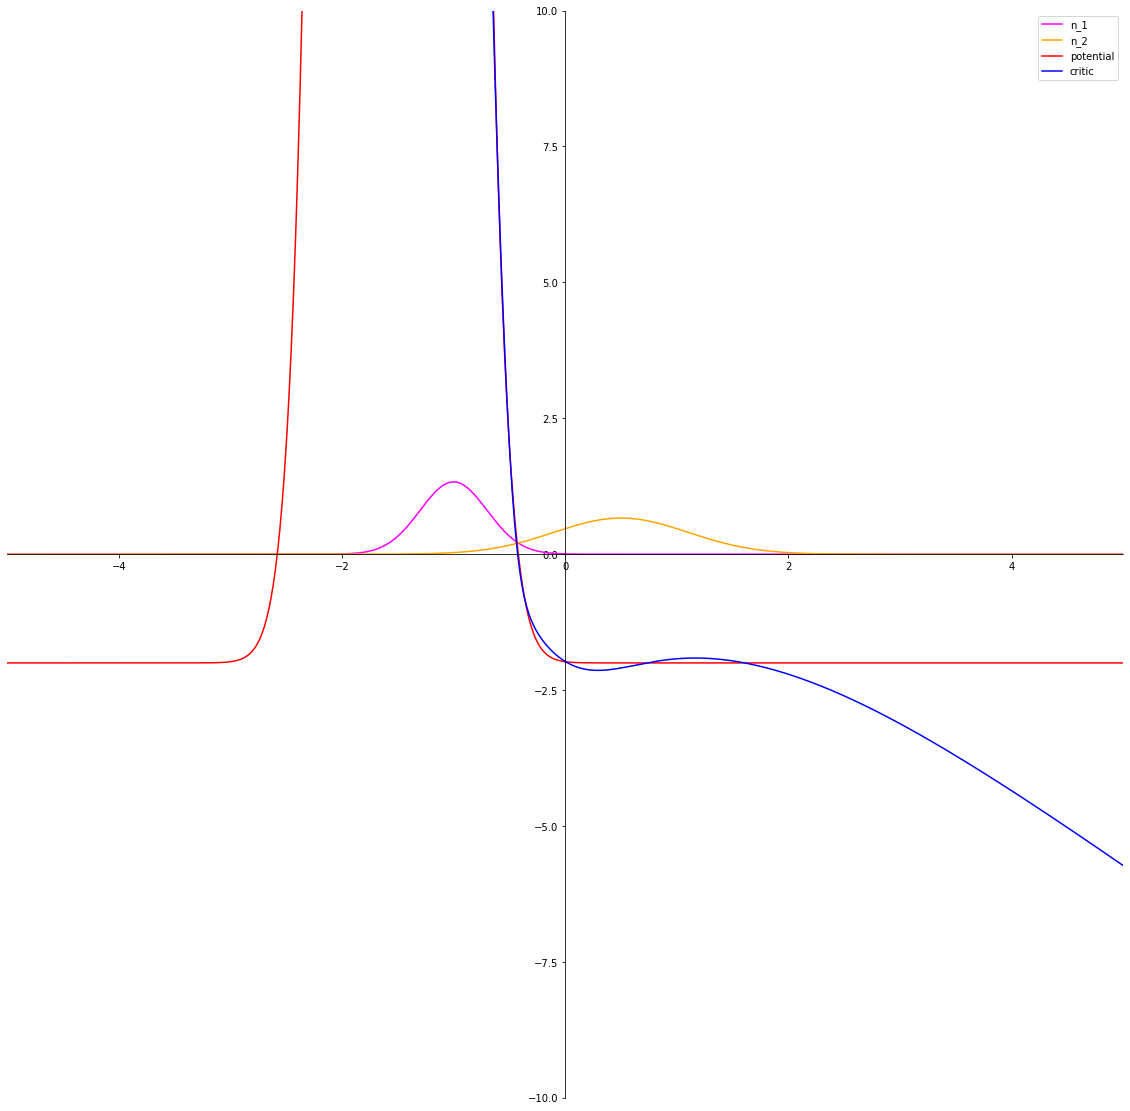

In [8]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlim([-5, 5])
ax.set_ylim([-10, 10])

x = np.linspace(-10,10,2000)
csiszar_potential = get_csiszar_potential(n_1, n_2, lambda x: 2 * x - 2)
csiszar_potential_x = np.array(list(map(csiszar_potential, x)))
critic = get_critic(n_1, n_2, conjugate_chi2)
critic_x = critic(torch.from_numpy(x).unsqueeze(1).float().cuda()).detach().cpu().numpy()
critic_x = critic_x - critic_x[1000] + csiszar_potential_x[1000]

plt.plot(x, n_1.log_prob(torch.from_numpy(x)).exp().numpy(), 'magenta', label='n_1')
plt.plot(x, n_2.log_prob(torch.from_numpy(x)).exp().numpy(), 'orange', label='n_2')
plt.plot(x, csiszar_potential_x, 'red', label='potential')
plt.plot(x, critic_x, 'blue', label='critic')

plt.legend(loc='upper right')

plt.show()

/home/dterjek/anaconda3/envs/torch/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


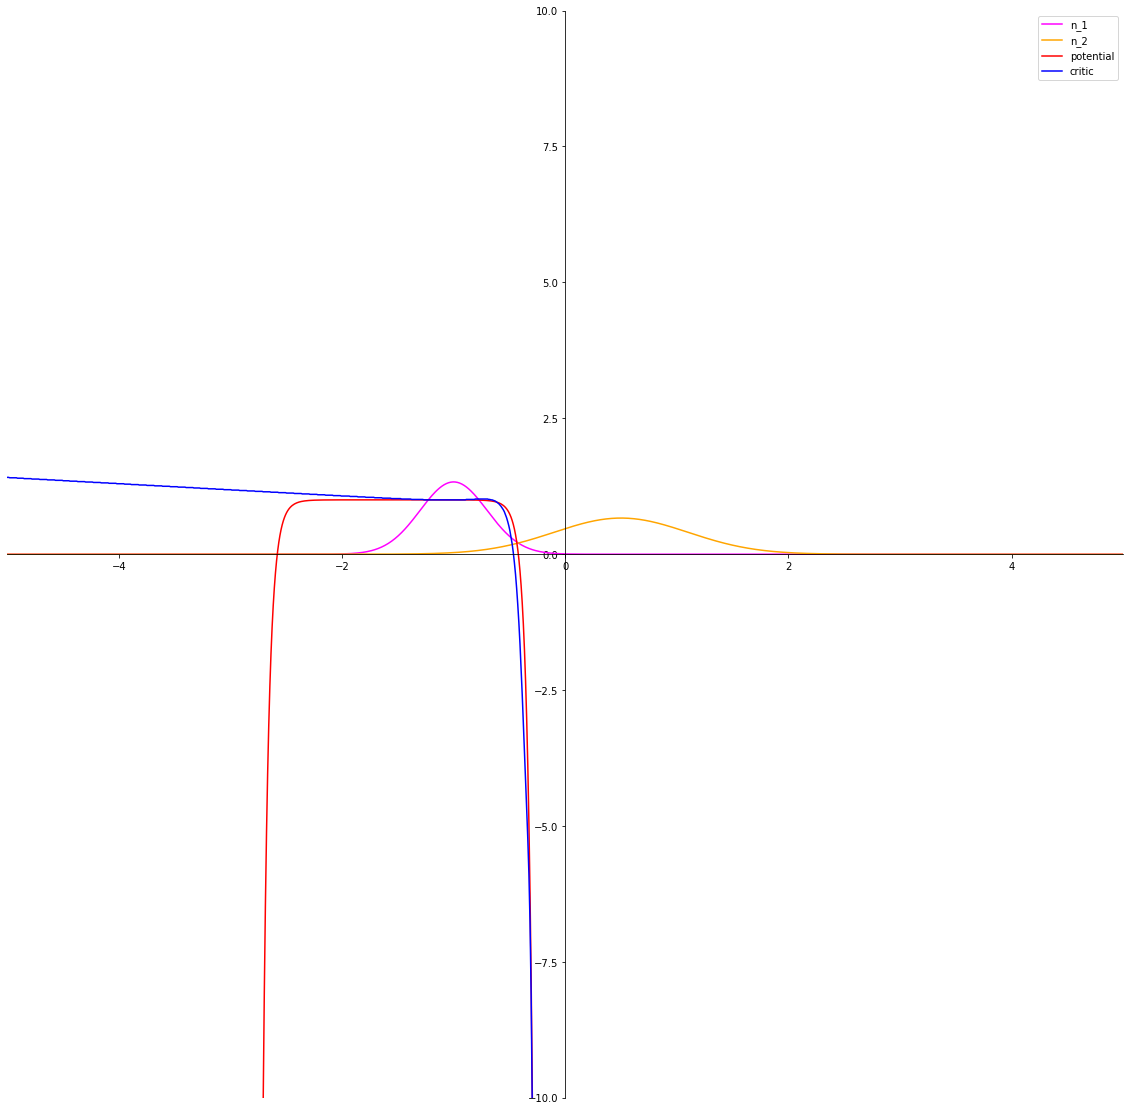

In [9]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlim([-5, 5])
ax.set_ylim([-10, 10])

x = np.linspace(-10,10,2000)
csiszar_potential = get_csiszar_potential(n_1, n_2, lambda x: 1 - 1 / (x ** 2))
csiszar_potential_x = np.array(list(map(csiszar_potential, x)))
critic = get_critic(n_1, n_2, conjugate_reverse_chi2)
critic_x = critic(torch.from_numpy(x).unsqueeze(1).float().cuda()).detach().cpu().numpy()
critic_x = critic_x - critic_x[900] + csiszar_potential_x[900]

plt.plot(x, n_1.log_prob(torch.from_numpy(x)).exp().numpy(), 'magenta', label='n_1')
plt.plot(x, n_2.log_prob(torch.from_numpy(x)).exp().numpy(), 'orange', label='n_2')
plt.plot(x, csiszar_potential_x, 'red', label='potential')
plt.plot(x, critic_x, 'blue', label='critic')

plt.legend(loc='upper right')

plt.show()

/home/dterjek/anaconda3/envs/torch/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


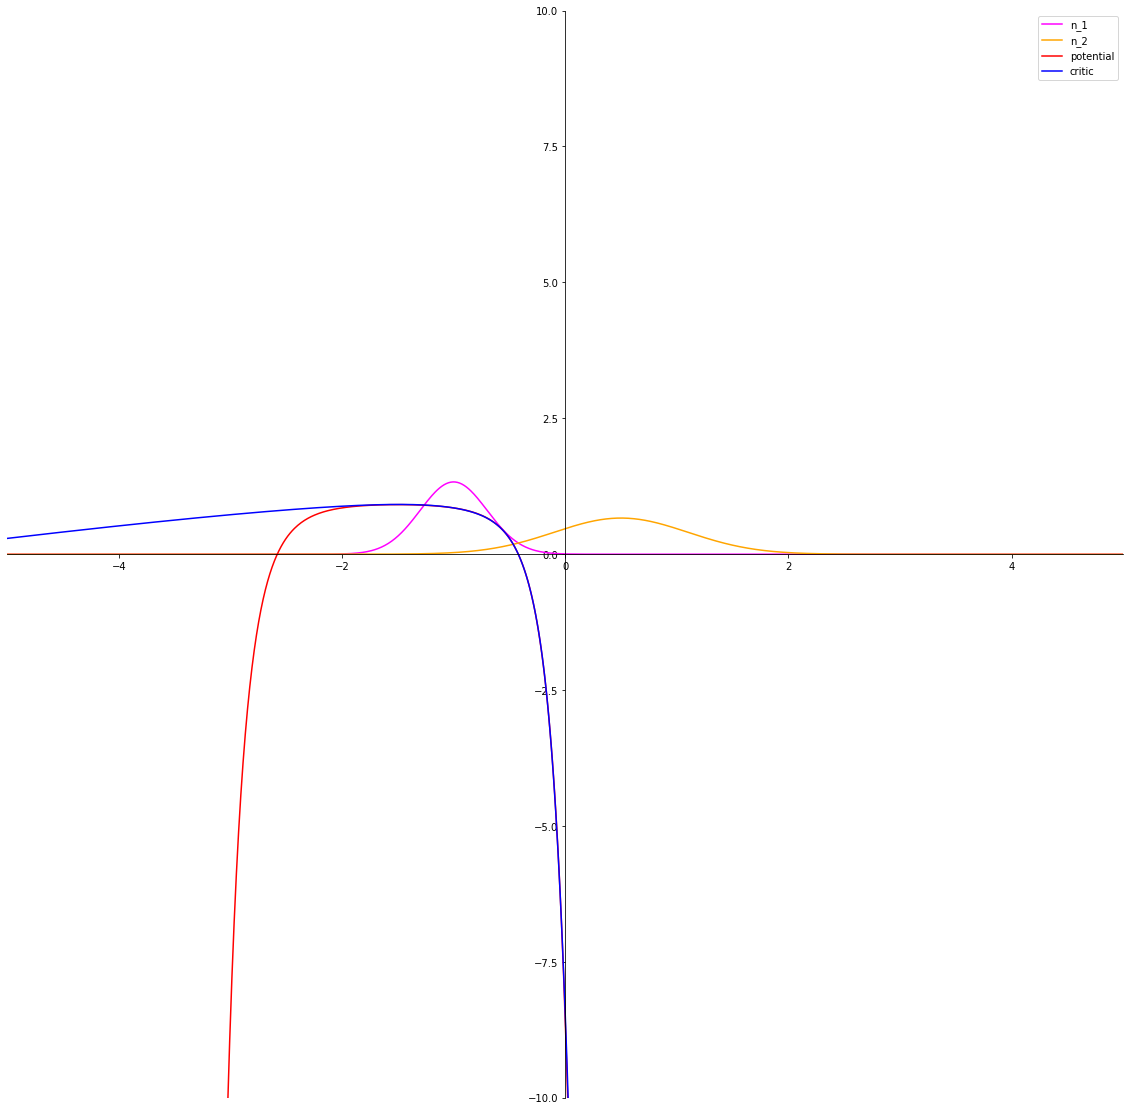

In [10]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlim([-5, 5])
ax.set_ylim([-10, 10])

x = np.linspace(-10,10,2000)
csiszar_potential = get_csiszar_potential(n_1, n_2, lambda x: 1 - 1 / (x ** (1 / 2)))
csiszar_potential_x = np.array(list(map(csiszar_potential, x)))
critic = get_critic(n_1, n_2, conjugate_hellinger2)
critic_x = critic(torch.from_numpy(x).unsqueeze(1).float().cuda()).detach().cpu().numpy()
critic_x = critic_x - critic_x[900] + csiszar_potential_x[900]

plt.plot(x, n_1.log_prob(torch.from_numpy(x)).exp().numpy(), 'magenta', label='n_1')
plt.plot(x, n_2.log_prob(torch.from_numpy(x)).exp().numpy(), 'orange', label='n_2')
plt.plot(x, csiszar_potential_x, 'red', label='potential')
plt.plot(x, critic_x, 'blue', label='critic')

plt.legend(loc='upper right')

plt.show()

/home/dterjek/anaconda3/envs/torch/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


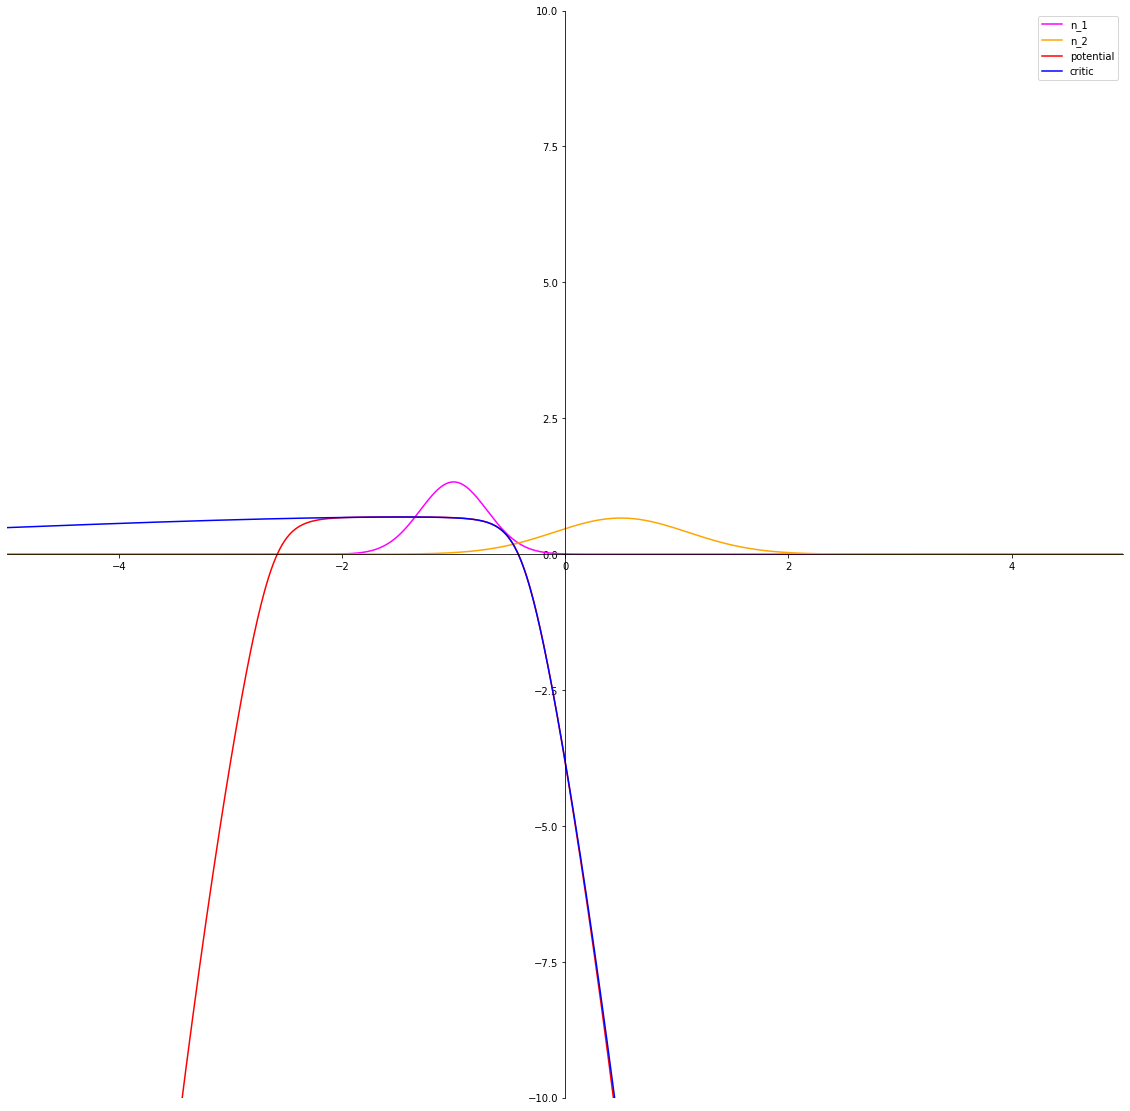

In [11]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlim([-5, 5])
ax.set_ylim([-10, 10])

x = np.linspace(-10,10,2000)
csiszar_potential = get_csiszar_potential(n_1, n_2, lambda x: torch.log(torch.tensor([x])).item() - torch.log(torch.tensor([x + 1])).item() + math.log(2))
csiszar_potential_x = np.array(list(map(csiszar_potential, x)))
critic = get_critic(n_1, n_2, conjugate_js)
critic_x = critic(torch.from_numpy(x).unsqueeze(1).float().cuda()).detach().cpu().numpy()
critic_x = critic_x - critic_x[950] + csiszar_potential_x[950]

plt.plot(x, n_1.log_prob(torch.from_numpy(x)).exp().numpy(), 'magenta', label='n_1')
plt.plot(x, n_2.log_prob(torch.from_numpy(x)).exp().numpy(), 'orange', label='n_2')
plt.plot(x, csiszar_potential_x, 'red', label='potential')
plt.plot(x, critic_x, 'blue', label='critic')

plt.legend(loc='upper right')

plt.show()

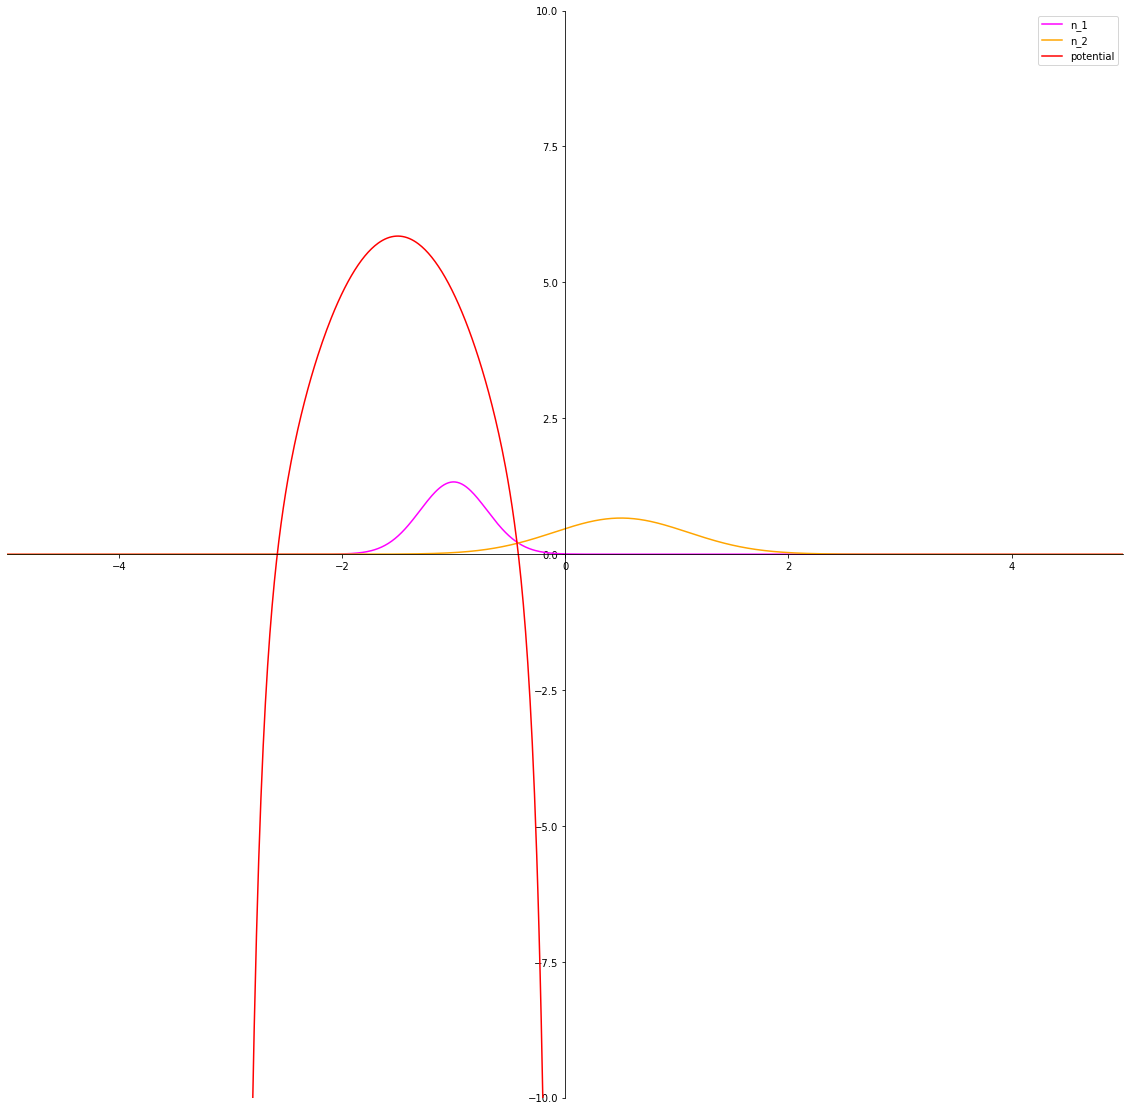

In [13]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlim([-5, 5])
ax.set_ylim([-10, 10])

x = np.linspace(-10,10,2000)
csiszar_potential = get_csiszar_potential(n_1, n_2, lambda x: torch.log(torch.tensor([x])).item() - 1 / x + 1)
csiszar_potential_x = np.array(list(map(csiszar_potential, x)))
# critic = get_critic(n_1, n_2, conjugate_jeffreys)
# critic_x = critic(torch.from_numpy(x).unsqueeze(1).float().cuda()).detach().cpu().numpy()
# critic_x = critic_x - critic_x[950] + csiszar_potential_x[950]

plt.plot(x, n_1.log_prob(torch.from_numpy(x)).exp().numpy(), 'magenta', label='n_1')
plt.plot(x, n_2.log_prob(torch.from_numpy(x)).exp().numpy(), 'orange', label='n_2')
plt.plot(x, csiszar_potential_x, 'red', label='potential')
# plt.plot(x, critic_x, 'blue', label='critic')

plt.legend(loc='upper right')

plt.show()

/home/dterjek/anaconda3/envs/torch/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


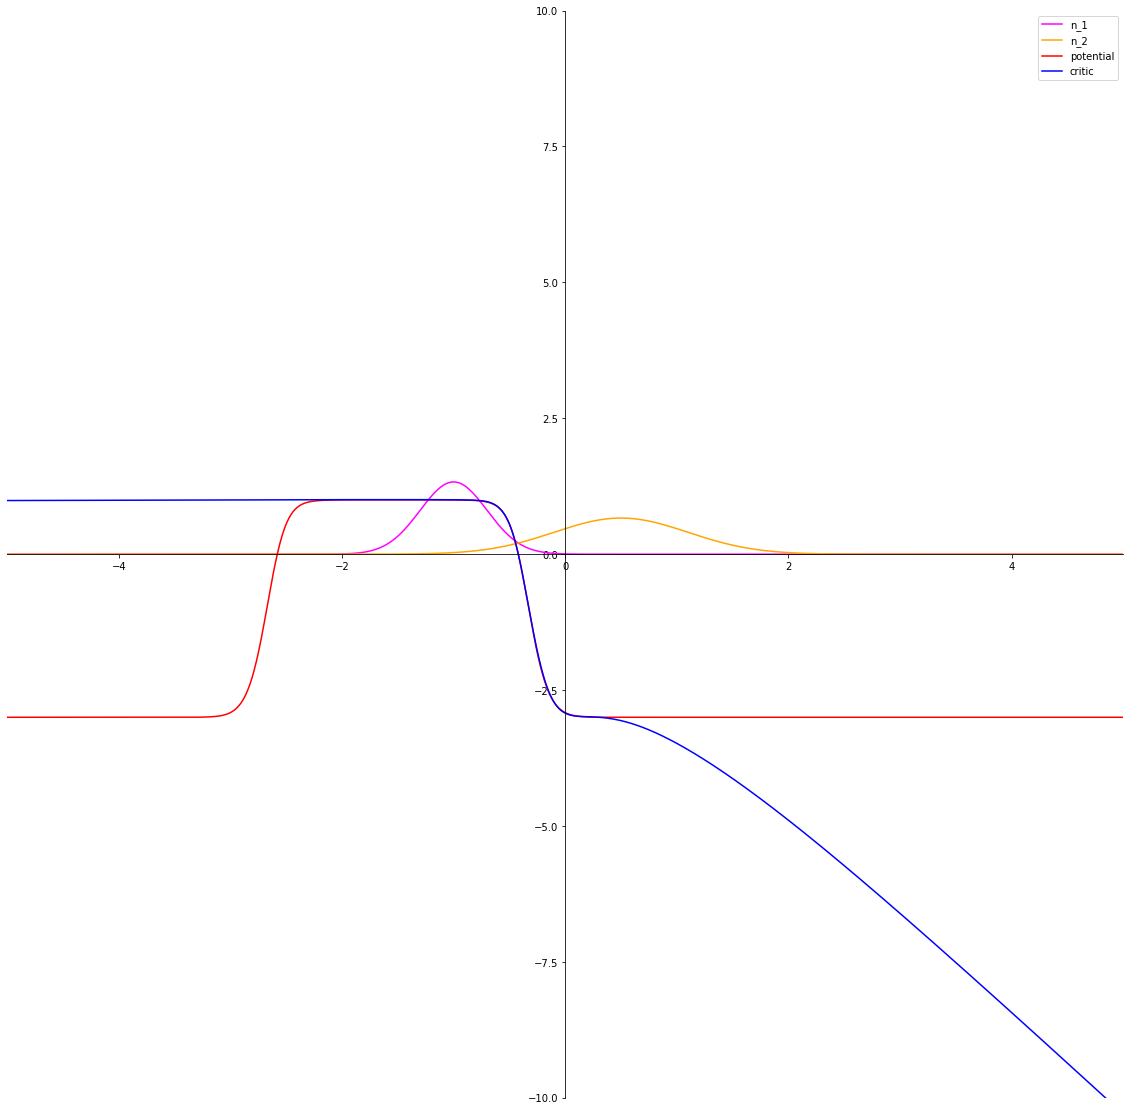

In [12]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlim([-5, 5])
ax.set_ylim([-10, 10])

x = np.linspace(-10,10,2000)
csiszar_potential = get_csiszar_potential(n_1, n_2, lambda x: ((x - 1) * (x + 3)) / ((x + 1) ** 2))
csiszar_potential_x = np.array(list(map(csiszar_potential, x)))
critic = get_critic(n_1, n_2, conjugate_triangular)
critic_x = critic(torch.from_numpy(x).unsqueeze(1).float().cuda()).detach().cpu().numpy()
critic_x = critic_x - critic_x[950] + csiszar_potential_x[950]

plt.plot(x, n_1.log_prob(torch.from_numpy(x)).exp().numpy(), 'magenta', label='n_1')
plt.plot(x, n_2.log_prob(torch.from_numpy(x)).exp().numpy(), 'orange', label='n_2')
plt.plot(x, csiszar_potential_x, 'red', label='potential')
plt.plot(x, critic_x, 'blue', label='critic')

plt.legend(loc='upper right')

plt.show()